# Template for Spectral and temporal modifications Lab


*From R. Badeau and G. Richard (with help from P. Vernhet); MAJ:2019,2024*

**python version >=3.6**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from copy import deepcopy
from math import ceil
import soundfile as sf
from scipy.signal.windows import hann

## Functions

In [2]:
def plot_sound(data, times, name="default_name", save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    if save:
        plt.savefig(name + ".png", dpi=100)
    plt.show()


def nextpow2(x):
    assert x > 0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2 ** (p - 1) < x <= x_
    return p, x_


def period(x, Fs, Pmin = 1 / 300, Pmax = 1 / 80, seuil=0.7):
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin * Fs).astype(int)
    Nmax = 1 + np.floor(Pmax * Fs).astype(int)
    Nmax = np.min([Nmax, N])

    Nfft = nextpow2(2 * N - 1)
    X = np.fft.fft(x, n=Nfft[1])
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax]) if Nmax > Nmin else r[Nmin:]
    I = np.argmax(r[Nmin:Nmax]) if Nmax > Nmin else np.argmax(r[Nmin:])
    P = I + Nmin
    corr = (rmax / r[0]) * (N / (N - P))
    voiced = corr > seuil if np.isscalar(corr) else (corr > seuil).all()
    if not (voiced):
        P = np.round(10e-3 * Fs)

    return P, voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
filename = 'aeiou.wav'
file_path = os.path.join(os.getcwd(), filename) 

### **Using Soundfile**

In [4]:
x, Fs = sf.read(file_path)

In [5]:
IPython.display.Audio(file_path)

In [6]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

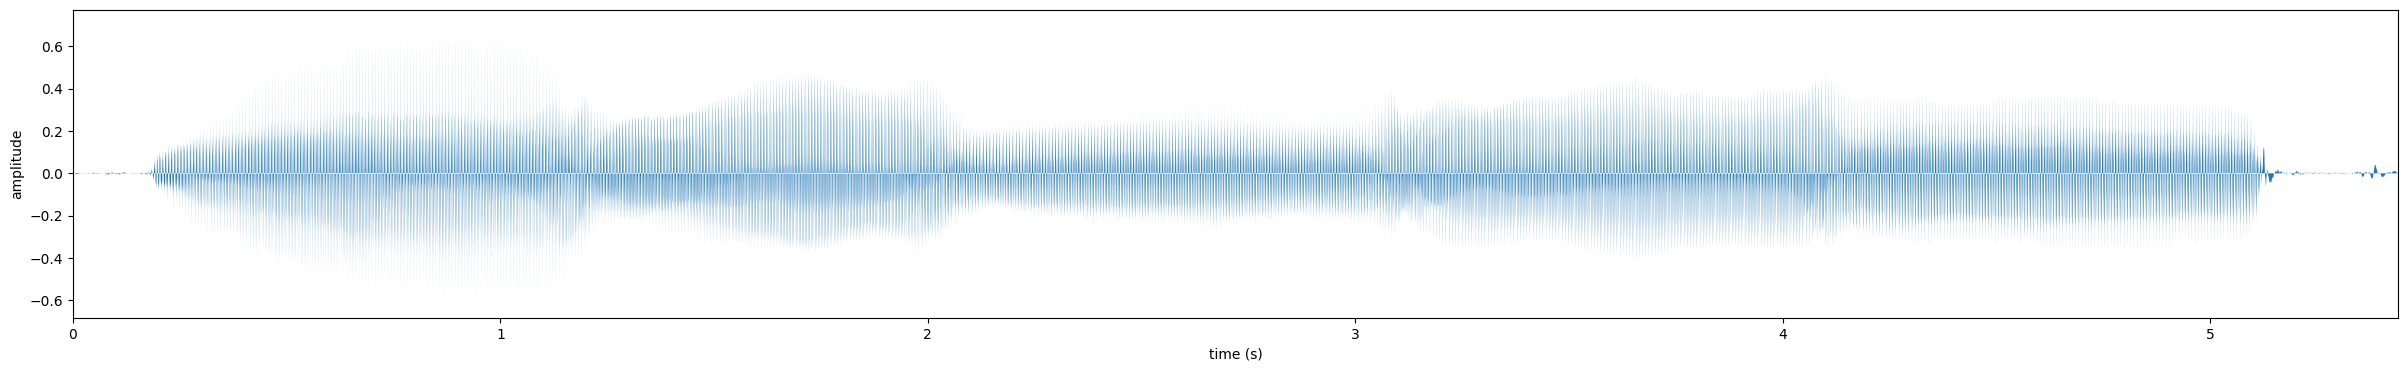

In [7]:
plot_sound(x, times)

In [8]:
sf.write('new_aeiou.wav', x, samplerate=Fs) # to write a new wave file

# PSOLA

In [9]:
audio = x.copy()
samplerate = Fs

## Analysis Pitch Marks

In [10]:
def AnalysisPitchMarks(s, Fs):
    # Initialize analysis marks matrix A with shape (3, number_of_marks)
    # The number_of_marks is unknown beforehand, so we start with an empty list
    A = []
    
    # Initialize the first analysis mark
    ta_prev = 0  
    Pa_prev = int(10e-3 * Fs)  # 10ms * Fs as the initial period
    
    n = 0  # Start recursion index
    while ta_prev < len(s):
        # Extract a short-term signal segment from s
        start = int(ta_prev)
        end = int(start + int(2.5 * Pa_prev))
        x = s[start:end] if end <= len(s) else s[start:]
        
        # Compute period and voicing using the period function
        P, voiced = period(x, Fs)
        
        # Update the analysis marks
        A.append([ta_prev, voiced, P])
        
        # Compute next ta using recursion
        ta_prev += P
        Pa_prev = P
        
        n += 1
    
    # Convert list to numpy array with shape (3, num_marks)
    A = np.array(A).T
    return A

In [11]:
# Analyze pitch marks
A = AnalysisPitchMarks(audio, samplerate)

## Synthesis

In [12]:
def Synthesis(s, Fs, A, B):
    # Check the array types and shapes
    if not isinstance(A, np.ndarray) or not isinstance(B, np.ndarray):
        raise ValueError("A and B must be numpy arrays")
    if A.ndim != 2 or B.ndim != 2:
        raise ValueError("A and B must be 2-dimensional arrays")

    # Initialize the synthesis signal y
    kend = B.shape[1] - 1  # Accessing the last column safely
    if kend < 0:
        raise ValueError("B has no columns")

    # Properly accessing the last elements in B
    ts_kend = B[0, kend].astype(int)  # time index in the last column of B
    an_kend = B[1, kend].astype(int) - 1  # adjusting MATLAB-style 1-based index to Python's 0-based index

    if an_kend >= A.shape[1] or an_kend < 0:
        raise ValueError("Index out of bounds for array A")

    # Calculate y_length safely
    y_length = int(ts_kend + A[2, an_kend])
    y = np.zeros(y_length)
    
    # Perform synthesis by recursion on k >= 1
    for k in range(len(B[0])):
        n_k = B[1, k].astype(int) - 1  # Convert 1-based index to 0-based
        t_s_k = int(B[0, k])
        t_a_n_k = int(A[0, n_k])
        P_a_n_k = int(A[2, n_k])
        
        # Extract a sequence x centered at t_a(n(k)) of length 2*P_a(n(k)) + 1
        x_start = max(t_a_n_k - P_a_n_k, 0)
        x_end = min(t_a_n_k + P_a_n_k + 1, len(s))
        x = s[x_start:x_end]
        
        # Apply a Hann window to the sequence x
        window = hann(len(x))
        x_windowed = x * window
        
        # Overlap-add the windowed sequence x into the synthesis signal y
        y_start = max(t_s_k - P_a_n_k, 0)
        y_end = min(t_s_k + P_a_n_k + 1, len(y))
        
        # Since x_windowed can be smaller than the range in y due to signal boundaries,
        # we calculate the actual start indices for overlap-adding
        y_range = y_end - y_start
        x_range = min(len(x_windowed), y_range)
        y[y_start:y_start + x_range] += x_windowed[:x_range]
    
    return y

In [13]:
# Perform simple synthesis without modification
B_simple = np.vstack((A[0, :], np.arange(1, A.shape[1] + 1)))  # B without modification
synthesized_audio = Synthesis(audio, samplerate, A, B_simple)

# Save synthesized audio for playback
output_path = 'synthesized_audio.wav'
sf.write(output_path, synthesized_audio, samplerate)

# Play synthesized audio
print("Synthesized Audio (No Modification):")
IPython.display.Audio(output_path)

Synthesized Audio (No Modification):


## Change Time Scale

In [14]:
def ChangeTimeScale(alpha, A, Fs):
    # Initialize the matrix B with two rows: times and indices of analysis marks
    ts = [1]  # Start with ts(0) = 1 (initializing at 1 for MATLAB compatibility if needed)
    n = [1]   # Start with n(1) = 1
    
    # Fill matrix B by adjusting ts and n based on factor alpha
    k = 0
    while True:
        current_n = int(np.floor(n[k]))  # Use floor to ensure we use an integer index for n
        if current_n >= len(A[0]):
            break  # Stop if the index exceeds the number of available analysis marks
        
        # Calculate the next ts(k)
        if k == 0:
            next_ts = ts[k]  # Initialize ts(0)
        else:
            next_ts = ts[k - 1] + int(A[2, current_n - 1])  # Pa(n[k]) where n[k] is 1-based

        # Append the calculated ts to the ts list
        ts.append(next_ts)
        
        # Calculate the next n(k)
        next_n = n[k] + 1/alpha
        n.append(next_n)
        
        k += 1  # Increment k for the next iteration
    
    # Convert ts and n to integer values suitable for indexing (adjusting for 1-based indexing if needed)
    ts = [int(t) for t in ts]
    n = [int(np.floor(nk)) for nk in n]
    
    # Ensure that indices in n are within the valid range of analysis marks
    n = [ni if ni < len(A[0]) else len(A[0]) for ni in n]
    
    # Stack ts and n to form matrix B
    B = np.array([ts[:-1], n[:-1]])  # Remove the last element to prevent out-of-bounds indexing

    return B


In [15]:
# Apply time scaling
alpha = 0.8  # Scaling factor for time (slow down the signal)
B_time_scaled = ChangeTimeScale(alpha, A, samplerate)
time_scaled_audio = Synthesis(audio, samplerate, A, B_time_scaled)

# Save time-scaled audio for playback
time_scaled_output_path = 'time_scaled_audio.wav'
sf.write(time_scaled_output_path, time_scaled_audio, samplerate)

# Display the time-scaled audio
print("Time-Scaled Audio:")
IPython.display.Audio(time_scaled_output_path)

Time-Scaled Audio:


# Chage Pitch Scale

In [16]:
def ChangePitchScale(beta, A, Fs):
    # Initialize the matrix B with two rows: times and indices of analysis marks
    ts = [1]  # Start with ts(0) = 1 for simplicity (assuming start at sample index 1 for clarity)
    n = [1]   # Start with n(1) = 1 assuming 1-based index as input

    # Fill matrix B by adjusting ts and n based on pitch scaling factor beta
    k = 0
    while k < A.shape[1] - 1:  # Ensure we do not go out of bounds
        current_n = int(n[k] - 1)  # Adjusting for 0-based index in Python
        if current_n >= A.shape[1]:
            break  # Stop if the index exceeds the number of available analysis marks

        # Calculate scale based on voiced or unvoiced
        if A[1, current_n] == 1:  # Assuming A[1, n] indicates voiced (1) or unvoiced (0)
            scale = 1 / beta
        else:
            scale = 1

        # Calculate the next ts(k)
        next_ts = ts[k] + scale * A[2, current_n]  # Pa(n(k)) scaled by the factor
        ts.append(int(next_ts))  # Store integer values in B

        # Calculate the next n(k)
        next_n = n[k] + scale
        n.append(next_n)

        k += 1  # Increment k for the next iteration

    # Stack ts and n to form matrix B, ensuring all indices are integers
    B = np.array([ts[:-1], [int(round(ni)) for ni in n[:-1]]])  # Remove the last element to prevent out-of-bounds indexing

    return B

In [17]:
# Apply pitch scaling with a chosen beta factor
beta = 1.2  # Example factor to decrease pitch
B_pitch_scaled = ChangePitchScale(beta, A, samplerate)
pitch_scaled_audio = Synthesis(audio, samplerate, A, B_pitch_scaled)

# Save time and pitch scaled audio for playback
pitch_scaled_output_path = 'pitch_scaled_audio.wav'
sf.write(pitch_scaled_output_path, pitch_scaled_audio, samplerate)

# Display the time-scaled audio
print("Time-Scaled Audio:")
IPython.display.Audio(pitch_scaled_output_path)


Time-Scaled Audio:


## Change Both Scales

In [18]:
def ChangeBothScales(alpha, beta, A, Fs):
    # Initialize the matrix B with two rows: times and indices of analysis marks
    ts = [1]  # Start with ts(0) = 1 (initializing at 1 for MATLAB compatibility if needed)
    n = [1]   # Start with n(1) = 1
    
    # Fill matrix B by adjusting ts and n based on factors alpha and beta
    k = 0
    while True:
        current_n = int(np.floor(n[k]))  # Use floor to ensure we use an integer index for n
        if current_n >= len(A[0]):
            break  # Stop if the index exceeds the number of available analysis marks
        
        # Calculate the next ts(k) with consideration of beta for pitch scaling
        if k == 0:
            next_ts = ts[k]  # Initialize ts(0)
        else:
            current_pitch = int(A[2, current_n - 1])  # Pa(n[k]) where n[k] is 1-based
            scaled_pitch = int(current_pitch / beta)  # Adjust pitch period by beta
            next_ts = ts[k - 1] + scaled_pitch  # Adjust timing using the scaled pitch
        
        # Append the calculated ts to the ts list
        ts.append(next_ts)
        
        # Calculate the next n(k) adjusted by alpha for time scaling
        next_n = n[k] + (1 / alpha)
        n.append(next_n)
        
        k += 1  # Increment k for the next iteration
    
    # Convert ts and n to integer values suitable for indexing (adjusting for 1-based indexing if needed)
    ts = [int(t) for t in ts]
    n = [int(np.floor(nk)) for nk in n]
    
    # Ensure that indices in n are within the valid range of analysis marks
    n = [ni if ni < len(A[0]) else len(A[0]) for ni in n]
    
    # Stack ts and n to form matrix B
    B = np.array([ts[:-1], n[:-1]])  # Remove the last element to prevent out-of-bounds indexing

    return B

In [19]:
# Apply both time and pitch scaling
alpha = 0.8  # Scaling factor for time
beta = 1.2   # Scaling factor for pitch
B_both_scaled = ChangeBothScales(alpha, beta, A, samplerate)
both_scaled_audio = Synthesis(audio, samplerate, A, B_both_scaled)

# Save time and pitch scaled audio for playback
both_scaled_output_path = 'both_scaled_audio.wav'
sf.write(both_scaled_output_path, both_scaled_audio, samplerate)

# Play time and pitch scaled audio
print("Time and Pitch Scaled Audio:")
IPython.display.Audio(both_scaled_output_path)

Time and Pitch Scaled Audio:
